In [14]:
%配置命令
format compact 

TODO:参考 http://mp.weixin.qq.com/s/ViwmnHWpTyFD-AybPUmmwQ 总结这个算法。

模型结论：单单就是由于随机刹车，就能产生拥堵。

In [95]:
%设置随机种子，这里设置固定的随机数种子保持每次运行的结果是一致的
seed = 1;
rng(seed,'twister') 


%设置模型参数
n = 500;%离散格子个数
rho = 0.15;%车辆密度
probs = [0, 0.08, 0.16, 0.24]; %刹车概率
times = 600;%运行时间
v_limit = 5;%最大速度

%建立结果矩阵，保存运行过程中的结果
road_store = zeros(times, n, length(probs));

for j = 1:length(probs)
    %得到当前测试的 刹车概率值
    p = probs(j);
    
    %建立车辆和车速矩阵（预分配内存）
    car_list = zeros(1,n);
    v = zeros(1,n);  

    %随机产生车辆
    %%得到随机的下标（下标在 1-n之内）
    rand_sort = randperm(n);%random permutation of the integers
    %%根据 车辆密度 设置有车的网格，有车则对应矩阵元素为1
    car_list(rand_sort(1:floor(n*rho))) = 1; %floor为取下界

    %%初始化 时间为1（最小值）时的 车辆结果
    road_store(1, :, j) = car_list;

    %计算 时间从 2 到 总数 的车辆结果
    for i = 2:times
        %找到第一辆车的 下标
        first_car_index = find(car_list==1, 1); %find(X, k)找到 X 中前 k 个不为零的元素下标
        %“ 首尾相接 ”，方便后续计算
        road_long = [car_list, car_list(1:first_car_index)];
        %计算 还未取模 的车辆位置下标
        all_car_index_without_mod = find(road_long==1);  
        %通过车辆的位置，使用 一阶差分 计算车辆前方（在我们的视角，就是右方）的空单元格数
        blank_num = diff(all_car_index_without_mod) - 1; %diff为一阶差分

        %找到所有车辆的下标
        all_car_index = find(car_list==1);
        %根据下标获取车辆速度
        car_v = v(all_car_index);
        %根据指定的规则，对车辆的速度进行 减速 或 加速 或 保持速度 这三种处理
        %%情况1：若 car_v 大于等于 前面的空格数，则 car_v 减低到 空格数
        %%情况2：若 car_v 小于前面的空格数 且 小于最大速度，则加速，速度每次+1
        %%情况3：若 car_v 小于前面的空格数 且 等于最大速度，则速度不变
        car_v = (car_v >= blank_num).*blank_num + ... %情况1
                (car_v < blank_num & car_v < v_limit).*(car_v + 1) + ... %情况2
                (car_v < blank_num & car_v == v_limit).*car_v; %情况3

        %随机选取要刹车的车辆        
        car_v = car_v - (car_v>0).*(rand(1, length(car_v)) < p);% rand生成 0-1 的随机数（均匀分布）
        %前进（通过取模做到，也即是从后面开出去的车要从前面开进来）
        all_car_index_new = mod(all_car_index + car_v, n);
        %修正：位置 0 为 n(n%n=0)
        all_car_index_new(all_car_index_new == 0) = n; 

        %更新公路中车辆的位置
        car_list = zeros(1,n); %更新前先重置为0， 避免上一次的结果影响下一次的运行
        car_list(all_car_index_new) = 1;
        %更新速度
        v = zeros(1,n);
        v(all_car_index_new) = car_v; 
        %记录结果
        road_store(i, :, j) = car_list; 
    end
end

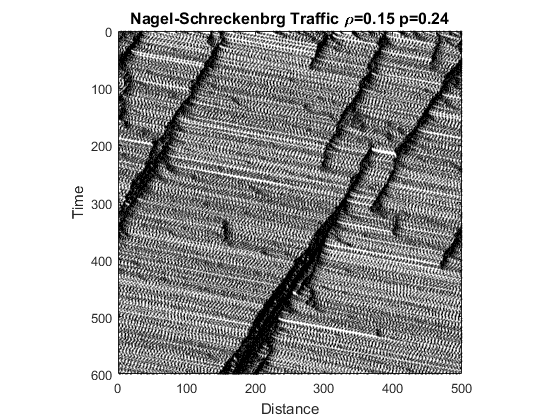

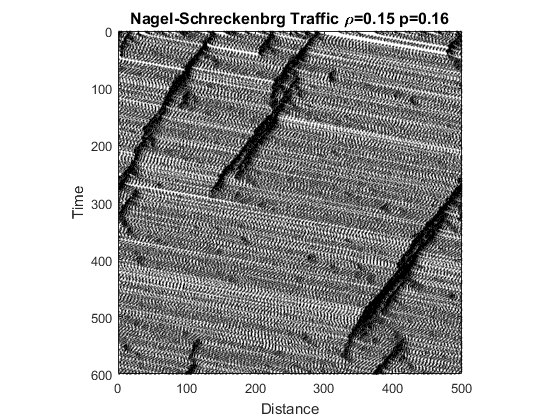

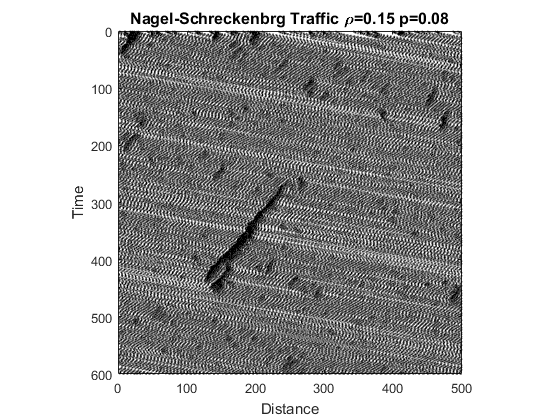

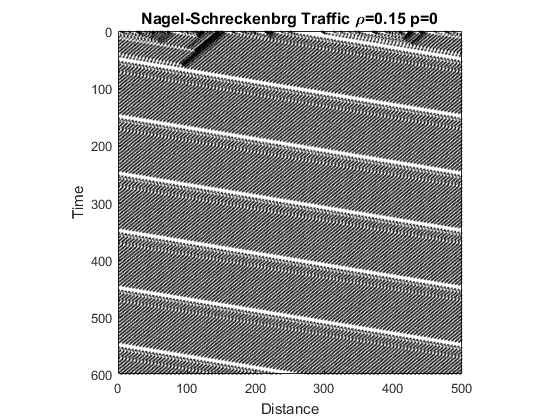

In [100]:
for j = 1:length(probs)
    %得到当前测试的 刹车概率值
    p = probs(j);
    [Times, Cars] = find(road_store(:, :, j));
    figure(j);
    plot(Cars, Times, 'k.','MarkerSize', 1);%MarkerSize用于设置 黑点 的大小
    set(gca,'ydir','reverse'); %由于默认y轴是从下到上是从小到大的，这里将其反转过来绘图
    xlabel('Distance');
    ylabel('Time');
    title(['Nagel-Schreckenbrg Traffic \rho=', num2str(rho),' p=', num2str(p)],'FontSize',12)
    axis square
end

# 参考资料

- 1.[产生随机数rand和randn中的“state”、“seed”和"twister"参数][1]

[1]:http://www.ilovematlab.cn/thread-315509-1-1.html